In [ ]:
!pip install shap

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 385 kB/s 


In [ ]:
# plot에 한국어 적용 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (45.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and di

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
# from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/codestates/Section3/test.csv', encoding='cp949')
print(df.shape)
df.head()

(11567, 10)


,id,spot_name,ymd,pm10,pm25,O3,NO2,CO,SO2,vol
0,1,종로구,2021-01-01 00:00,26.0,14.0,0.024,0.015,0.5,0.003,25.0
1,2,용산구,2021-01-01 00:00,36.0,11.0,0.017,0.017,0.4,0.003,162.0
2,3,중구,2021-01-01 00:00,29.0,16.0,0.018,0.021,0.5,0.003,116.0
3,4,은평구,2021-01-01 00:00,32.0,11.0,0.021,0.018,0.5,0.004,215.0
4,6,마포구,2021-01-01 00:00,23.0,12.0,0.011,0.029,0.5,0.003,30.0


결측치 제거

In [ ]:
print(df.isnull().sum())
df = df.drop(columns='id')
df.head()

id           0
spot_name    0
ymd          0
pm10         0
pm25         0
O3           0
NO2          0
CO           0
SO2          0
vol          0
dtype: int64


,spot_name,ymd,pm10,pm25,O3,NO2,CO,SO2,vol
0,종로구,2021-01-01 00:00,26.0,14.0,0.024,0.015,0.5,0.003,25.0
1,용산구,2021-01-01 00:00,36.0,11.0,0.017,0.017,0.4,0.003,162.0
2,중구,2021-01-01 00:00,29.0,16.0,0.018,0.021,0.5,0.003,116.0
3,은평구,2021-01-01 00:00,32.0,11.0,0.021,0.018,0.5,0.004,215.0
4,마포구,2021-01-01 00:00,23.0,12.0,0.011,0.029,0.5,0.003,30.0


In [ ]:
df = df.drop(df[df['vol']==0].index)
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(10251, 10)


,id,spot_name,ymd,pm10,pm25,O3,NO2,CO,SO2,vol
0,1,종로구,2021-01-01 00:00,26.0,14.0,0.024,0.015,0.5,0.003,25.0
1,2,용산구,2021-01-01 00:00,36.0,11.0,0.017,0.017,0.4,0.003,162.0
2,3,중구,2021-01-01 00:00,29.0,16.0,0.018,0.021,0.5,0.003,116.0
3,4,은평구,2021-01-01 00:00,32.0,11.0,0.021,0.018,0.5,0.004,215.0
4,6,마포구,2021-01-01 00:00,23.0,12.0,0.011,0.029,0.5,0.003,30.0


데이터 시각화

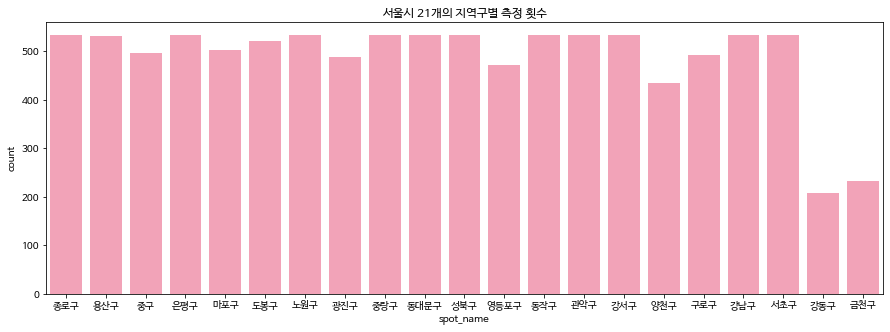

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.subplots(figsize=(15, 5))
plt.title('서울시 21개의 지역구별 측정 횟수')
sns.countplot(x='spot_name', data=df, color='#FF96b2');

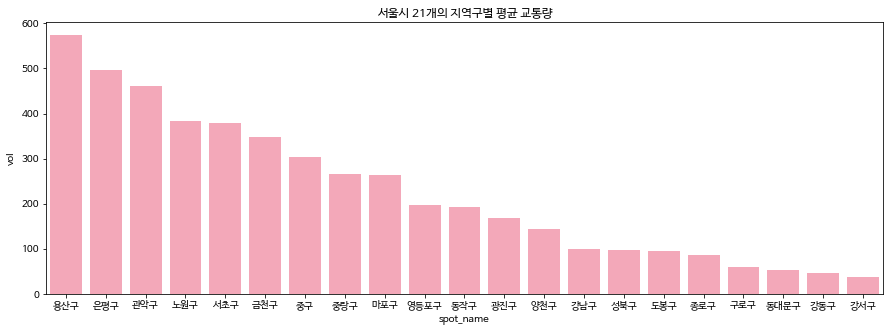

In [ ]:
plt.subplots(figsize=(15, 5))
plt.title('서울시 21개의 지역구별 평균 교통량')
group_spot = df[['spot_name', 'vol']].groupby('spot_name').mean().sort_values('vol', ascending=False).reset_index()
sns.barplot(x='spot_name', y='vol', data=group_spot, color='#FF9bb2');

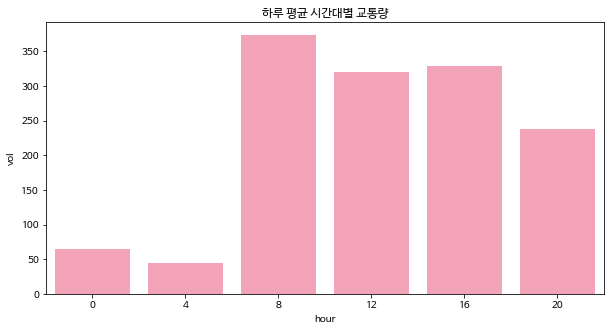

In [ ]:
df['hour'] = df['ymd'].apply(lambda x :int(x.split()[1].split(':')[0]))
group_time = df[['hour', 'vol']].groupby('hour').mean().sort_values('vol', ascending=False).reset_index()
plt.subplots(figsize=(10, 5))
plt.title('하루 평균 시간대별 교통량')
sns.barplot(x='hour', y='vol', data=group_time, color='#FF96b2');
df = df.drop(columns='ymd')

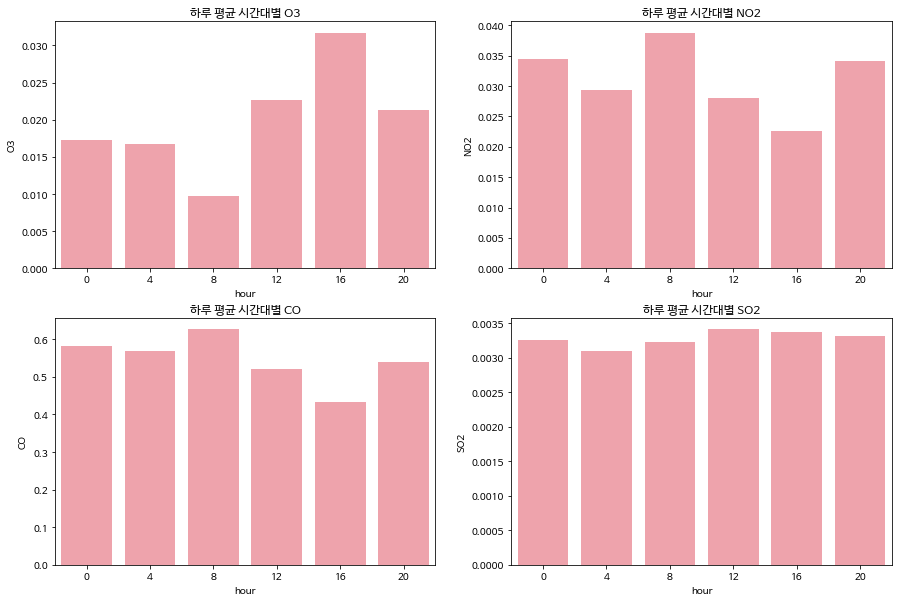

In [ ]:
cnt = 1
plt.subplots(figsize=(15, 10))
for column in df.columns[3:7]:
  grouy_weather = df[['hour', column]].groupby('hour').mean().sort_values(column, ascending=False).reset_index()
  plt.subplot(2, 2, cnt)
  plt.title('하루 평균 시간대별 ' + column)
  sns.barplot(x='hour', y=column, data=grouy_weather, color='#FB96a2');
  cnt+=1

Training 준비

In [ ]:
train = df.copy()
train, test = train_test_split(train, test_size=0.05, random_state=2)
train, val = train_test_split(train, test_size=0.15, random_state=2)
train.shape, val.shape, test.shape

((8277, 9), (1461, 9), (513, 9))

In [ ]:
target = 'vol'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
# 기준 모델
y_pred = y_train.mean()
y_pred = [y_pred] * len(y_train)
baseline = mean_absolute_error(y_train, y_pred)
print('기준모델 mae:', baseline)

기준모델 mae: 193.44522517707196


In [ ]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

model = xgboost.XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )


# 모델 저장
filename = 'xgb_model.model'
model.save_model(filename)
# 모델 불러오기
# new_xgb_model = xgb.XGBRegressor() # 모델 초기화
# new_xgb_model.load_model(filename) # 모델 불러오기

import pickle

with open('encoder.pkl','wb') as pickle_file:
    pickle.dump(X_train_encoded, pickle_file)

[0]	validation_0-rmse:283.925	validation_1-rmse:284.485
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:246.546	validation_1-rmse:247.665
[2]	validation_0-rmse:218.829	validation_1-rmse:220.434
[3]	validation_0-rmse:197.011	validation_1-rmse:198.838
[4]	validation_0-rmse:181.706	validation_1-rmse:183.635
[5]	validation_0-rmse:170.849	validation_1-rmse:172.711
[6]	validation_0-rmse:163.007	validation_1-rmse:165.249
[7]	validation_0-rmse:156.768	validation_1-rmse:158.244
[8]	validation_0-rmse:149.82	validation_1-rmse:151.454
[9]	validation_0-rmse:146.172	validation_1-rmse:147.677
[10]	validation_0-rmse:140.585	validation_1-rmse:142.279
[11]	validation_0-rmse:136.057	validation_1-rmse:137.165
[12]	validation_0-rmse:133.75	validation_1-rmse:135.15
[13]	validation_0-rmse:132.332	validation_1-rmse:133.541
[14]	validation_0-rmse:129.45	validation_1-rmse:130.879


모델 성능지표

In [ ]:
y_pred = model.predict(X_test_encoded)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('mae:', mae, ',mse:', mse, ',r2:', r2)

mae: 49.90311588088439 ,mse: 6178.445191493812 ,r2: 0.8963995990183271


모델 저장

In [ ]:
import pickle

with open('model.pkl','wb') as pickle_file:     # xgboosts는 model.save_model()이용
    pickle.dump(model, pickle_file)

with open('encoder.pkl','wb') as pickle_file:
    pickle.dump(encoder, pickle_file)

특정 중요도

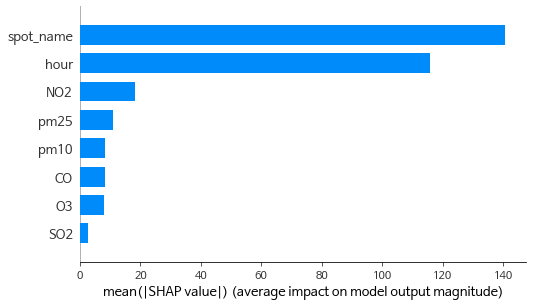

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_encoded.iloc[:300])
shap.summary_plot(shap_values, X_val_encoded.iloc[:300], plot_type="bar")